In [1]:
import re

In [1]:
import sys
import os

In [2]:
script_path = "configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper.py"

In [3]:
script_path = script_path[:-3]

In [4]:
script_path

'configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [5]:
new_path = script_path.replace("configs", "../results")

In [6]:
new_path

'../results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [7]:
with open(new_path + "/test_file.txt", 'w') as f:
    f.write("test")

In [7]:
new_path = os.path.dirname(new_path)

NameError: name 'os' is not defined

In [8]:
import_name = new_path + "/"

In [9]:
script = __import__(import_name)

ModuleNotFoundError: No module named 'results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [1]:
import tensorflow as tf

In [2]:
import pennylane as qml
import numpy as np

In [3]:
def variational_layer(wires, params):
    [[qml.RY(params[2*i], wires[i]),
     qml.RZ(params[(i*2)+1], wires[i])] for i in range(len(wires))]

In [4]:
dev = qml.device("default.qubit", wires = 4)
params = [1,2,3,4,5,6,7,8]
@qml.qnode(dev)
def circuit(params):
    variational_layer(range(4), params)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

print(qml.draw(circuit)(params))

0: ──RY(1.00)──RZ(2.00)─┤ ╭<Z@Z>
1: ──RY(3.00)──RZ(4.00)─┤ ╰<Z@Z>
2: ──RY(5.00)──RZ(6.00)─┤       
3: ──RY(7.00)──RZ(8.00)─┤       


In [5]:
def entangling_layer(wires):
    qml.CZ(wires = [0,1])
    qml.CZ(wires = [1,2])
    qml.CZ(wires = [2,3])
    qml.CZ(wires = [3,0])

In [6]:
def data_encoding(wires, data):
    [qml.RX(data[i], wires[i], id = f"x_{i}") for i in range(len(wires))]

In [7]:
dev = qml.device("default.qubit", wires = 4)

num_layers = 2

@qml.qnode(dev)
def schuld_datareup(params, data):
    for l in range(num_layers):
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
        data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [8]:
@qml.qnode(dev)
def basic_datareup(params, data):
    for l in range(num_layers-1):
        data_encoding(range(4), data)
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
    data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers-1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [9]:
data = np.random.uniform(-0.05,0.05, size=4)
params_schuld =[[np.random.uniform(0, np.pi) for i in range(8)] for j in range(num_layers + 1)]
params_basic = params_schuld[:-1]

In [10]:
print(qml.draw(schuld_datareup)(params_schuld, data))

0: ──RY(1.08)──RZ(0.02)─╭●───────╭Z──RX(0.00)───RY(1.78)──RZ(0.81)─╭●───────╭Z──RX(0.00)───RY(2.77)
1: ──RY(0.68)──RZ(2.59)─╰Z─╭●────│───RX(-0.04)──RY(0.48)──RZ(1.99)─╰Z─╭●────│───RX(-0.04)──RY(2.87)
2: ──RY(0.30)──RZ(1.44)────╰Z─╭●─│───RX(-0.01)──RY(0.88)──RZ(0.08)────╰Z─╭●─│───RX(-0.01)──RY(2.64)
3: ──RY(1.90)──RZ(0.63)───────╰Z─╰●──RX(0.05)───RY(1.55)──RZ(0.77)───────╰Z─╰●──RX(0.05)───RY(1.89)

───RZ(1.16)─┤ ╭<Z@Z>
───RZ(1.95)─┤ ╰<Z@Z>
───RZ(0.04)─┤       
───RZ(0.13)─┤       


In [11]:
print(qml.draw(basic_datareup)(params_basic, data))

0: ──RX(0.00)───RY(1.08)──RZ(0.02)─╭●───────╭Z──RX(0.00)───RY(1.78)──RZ(0.81)─┤ ╭<Z@Z>
1: ──RX(-0.04)──RY(0.68)──RZ(2.59)─╰Z─╭●────│───RX(-0.04)──RY(0.48)──RZ(1.99)─┤ ╰<Z@Z>
2: ──RX(-0.01)──RY(0.30)──RZ(1.44)────╰Z─╭●─│───RX(-0.01)──RY(0.88)──RZ(0.08)─┤       
3: ──RX(0.05)───RY(1.90)──RZ(0.63)───────╰Z─╰●──RX(0.05)───RY(1.55)──RZ(0.77)─┤       


In [12]:
from pennylane.fourier import coefficients, circuit_spectrum
freqs_schuld = circuit_spectrum(schuld_datareup)(params_schuld, data)
freqs_basic = circuit_spectrum(basic_datareup)(params_basic, data)

In [13]:
for k,v in freqs_schuld.items():
    print(k, ":", v)

for k,v in freqs_basic.items():
    print(k, ":", v)

x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]
x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]


In [14]:
freqs_schuld["x_0"]

[-2.0, -1.0, 0, 1.0, 2.0]

In [23]:
for i, freq in enumerate(list(freqs_schuld.keys())):
    print(freq, i)

x_0 0
x_1 1
x_2 2
x_3 3


In [36]:
from functools import partial
partial_schuld_circuit = partial(schuld_datareup, params_schuld)
partial_basic_circuit = partial(basic_datareup, params_basic)

coeffs_schuld = coefficients(partial_schuld_circuit, 4, 2)
coeffs_basic = coefficients(partial_basic_circuit, 4, 2)

In [37]:
coeffs_schuld

array([[[[-3.36432758e-03+0.00000000e+00j,
           8.50737979e-04-5.41607078e-04j,
           4.31876757e-18-2.85188539e-19j,
           4.31876757e-18+2.85188539e-19j,
           8.50737979e-04+5.41607078e-04j],
         [-1.82399564e-03+1.87960614e-02j,
          -1.03925408e-02+6.10105621e-04j,
          -1.56725183e-18-1.46886714e-18j,
           1.12225948e-18-4.23017702e-18j,
          -5.31058819e-03-1.41866471e-03j],
         [ 4.14945855e-19+4.68791672e-18j,
          -4.79095930e-18-1.85754190e-18j,
           1.29645644e-18+7.01387146e-19j,
          -3.95245578e-18+1.81748529e-18j,
           9.26342336e-20+2.65690248e-18j],
         [ 4.14945855e-19-4.68791672e-18j,
           9.26342336e-20-2.65690248e-18j,
          -3.95245578e-18-1.81748529e-18j,
           1.29645644e-18-7.01387146e-19j,
          -4.79095930e-18+1.85754190e-18j],
         [-1.82399564e-03-1.87960614e-02j,
          -5.31058819e-03+1.41866471e-03j,
           1.12225948e-18+4.23017702e-18j,
       

In [38]:
coeffs_basic

array([[[[-1.34623405e-02+0.00000000e+00j,
          -9.14823772e-18+1.57860477e-18j,
          -1.33235437e-18-4.77360464e-18j,
          -1.33235437e-18+4.77360464e-18j,
          -9.14823772e-18-1.57860477e-18j],
         [-5.68434189e-18+3.67516605e-19j,
          -4.81774388e-05+2.10538287e-18j,
           4.24813056e-18+2.87313830e-19j,
           1.07732945e-17+5.02003162e-18j,
          -4.81774388e-05-6.52788120e-18j],
         [-4.81559237e-19+8.69184417e-19j,
           6.53115608e-20+1.80312353e-18j,
           1.25572550e-18+1.84913837e-18j,
          -1.06744204e-18+4.24135606e-19j,
          -4.62277708e-18-1.58879995e-18j],
         [-4.81559237e-19-8.69184417e-19j,
          -4.62277708e-18+1.58879995e-18j,
          -1.06744204e-18-4.24135606e-19j,
           1.25572550e-18-1.84913837e-18j,
           6.53115608e-20-1.80312353e-18j],
         [-5.68434189e-18-3.67516605e-19j,
          -4.81774388e-05+6.52788120e-18j,
           1.07732945e-17-5.02003162e-18j,
       

In [39]:
from pennylane.fourier.visualize import *
import matplotlib.pyplot as plt

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

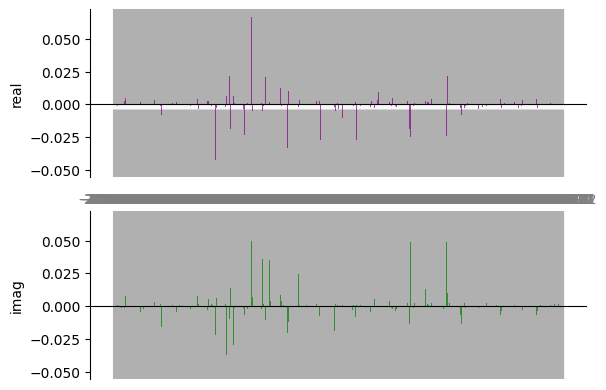

In [41]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_schuld, 4, ax)

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

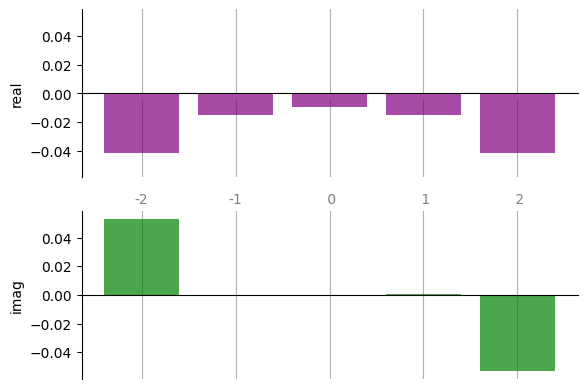

In [209]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_basic, 1, ax)

In [98]:
@qml.qnode(dev)
def simple_circuit(x):
    qml.RX(x[0], wires=0)
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(0))

In [99]:
coeffs = coefficients(simple_circuit, 1, 2)

In [291]:
dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def simple_circuit(params, data):
    qml.RX(params[0], wires=0)
    qml.RY(data[0], wires = 0, id = "x")
    qml.RX(params[1], wires = 0)
    qml.RY(data[1], wires = 0, id = "x")
    qml.RX(params[2], wires = 0)
    return qml.expval(qml.PauliZ(0))

In [294]:
data = [0,1]
params = [0.5,0.3,0.8]

In [295]:
simple_freqs = circuit_spectrum(simple_circuit)(params, data)

In [296]:
for k,v in simple_freqs.items():
    print(k, ":", v)

x : [-2.0, -1.0, 0, 1.0, 2.0]


In [297]:
from functools import partial

In [301]:
partial_circuit = partial(simple_circuit, params)
coeffs = coefficients(partial_circuit,2,1,lowpass_filter=True)

In [302]:
coeffs

array([[-0.32855821+0.j, -0.04935468+0.j, -0.04935468+0.j],
       [-0.09302078+0.j,  0.29888181+0.j, -0.00682701+0.j],
       [-0.09302078+0.j, -0.00682701+0.j,  0.29888181+0.j]])

In [287]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y

In [288]:
def f(x):
    return np.array([simple_circuit(params,x_) for x_ in x])

In [289]:
coeffs = fourier_coefficients(f, 1)

In [290]:
coeffs

array([-0.14167993+0.00000000e+00j,  0.41919332-1.28197512e-16j])

In [1]:
import pennylane as qml
import numpy as np

In [168]:
params = [np.random.uniform(0, np.pi) for i in range(6)]

In [181]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [182]:
results = circuit(params)
results = results[0] * results[1]
results

tensor(0.00106099, requires_grad=True)

In [183]:
@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    #qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [184]:
result = circuit(params)
result

tensor(-0.03021677, requires_grad=True)

In [1]:
from fourier_analysis.pennylane_operations import *
from fourier_analysis.pennylane_fourier import *
import pennylane as qml
import numpy as np

In [2]:
operations = QMLOperations()

In [3]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev)
def circuit(param):
    operations.skolik_entangling_layer(range(4))
    qml.RX(param, wires = 0)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [4]:
print(qml.draw(circuit)(5))

0: ─╭●───────╭●──RX(5.00)─┤ ╭<Z@Z>
1: ─╰Z─╭●────│────────────┤ ╰<Z@Z>
2: ────╰Z─╭●─│────────────┤       
3: ───────╰Z─╰Z───────────┤       


In [5]:
def operations():
    qml.Hadamard(wires = 0)

In [6]:
def circuit(param):
    operations()
    qml.RX(param, wires = 0)
    return qml.sample(qml.PauliZ(0))

In [7]:
dev = qml.device("default.qubit", wires = 1, shots = 5)
qnode = qml.QNode(circuit, dev)


In [8]:
print(qml.draw(qnode)(5))

0: ──H──RX(5.00)─┤  Sample[Z]


In [1]:
from fourier_analysis.pennylane_operations import *
from fourier_analysis.pennylane_fourier import *
import pennylane as qml
import numpy as np

In [2]:
num_qubits = 4
num_layers = 2
circuit_arch = "skolik"
data_reuploading = "schuld"
measurement = "ZZ"
weights = np.random.uniform(0, np.pi, size = (num_layers + 1, num_qubits*2))
data = np.random.uniform(-0.05, 0.05)

fourier_analysis = Fourier_Analysis(num_qubits, num_layers, circuit_arch, data_reuploading, measurement, weights, data)

In [3]:
fourier_analysis.draw_circuit()

0: ──RY(2.23)──RZ(2.98)─╭●───────╭●──RX(0.03)──RY(0.67)──RZ(0.81)─╭●───────╭●──RX(0.03)──RY(2.92)
1: ──RY(1.46)──RZ(2.21)─╰Z─╭●────│───RX(0.03)──RY(3.03)──RZ(2.11)─╰Z─╭●────│───RX(0.03)──RY(2.93)
2: ──RY(0.64)──RZ(1.91)────╰Z─╭●─│───RX(0.03)──RY(1.52)──RZ(2.79)────╰Z─╭●─│───RX(0.03)──RY(2.61)
3: ──RY(1.32)──RZ(0.25)───────╰Z─╰Z──RX(0.03)──RY(2.26)──RZ(1.87)───────╰Z─╰Z──RX(0.03)──RY(1.54)

───RZ(2.80)─┤ ╭<Z@Z>
───RZ(0.48)─┤ ╰<Z@Z>
───RZ(2.14)─┤       
───RZ(1.38)─┤       


In [4]:
freqs = fourier_analysis.circuit_spectrum()

for k,v in freqs.items():
    print(k, ":", v)

x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]


In [5]:
coeffs = fourier_analysis.fourier_coefficients()

In [6]:
coeffs

array([-0.01769918+0.j        ,  0.03238079+0.05311799j,
       -0.05427004+0.03499296j, -0.05427004-0.03499296j,
        0.03238079-0.05311799j])

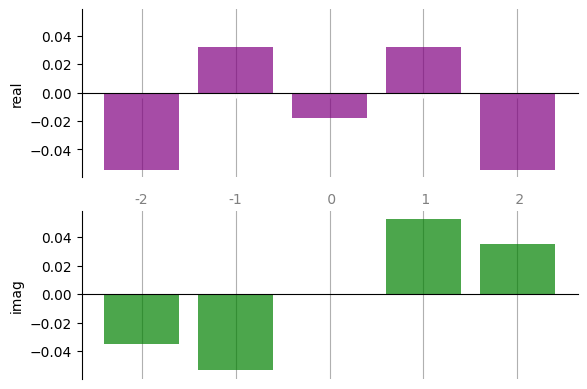

In [7]:
fourier_analysis.plot_coefficients()

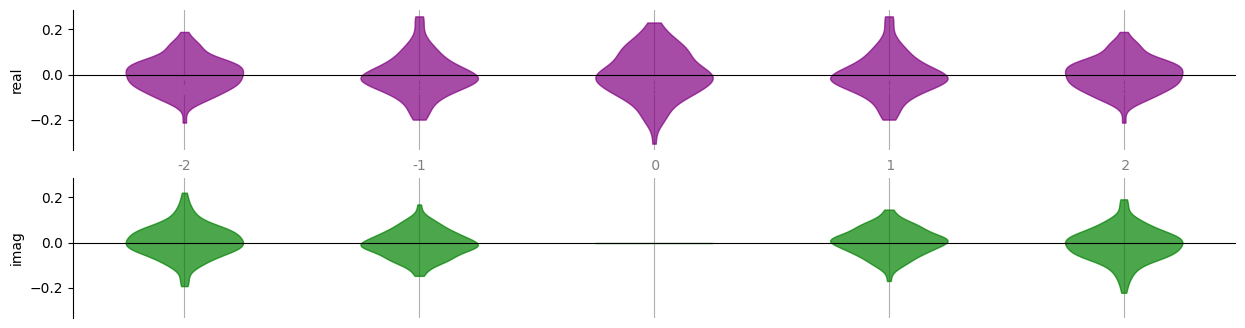

In [8]:
fourier_analysis.plot_random_coefficients_distribution()

In [41]:
def variational_layer(wires, params):
    [[qml.RY(params[2*i], wires[i]),
     qml.RZ(params[(i*2)+1], wires[i])] for i in range(len(wires))]
    
def entangling_layer(wires):
    qml.CZ(wires = [0,1])
    qml.CZ(wires = [1,2])
    qml.CZ(wires = [2,3])
    qml.CZ(wires = [3,0])

def data_encoding_1d(wires, data):
    [qml.RX(data, wires[i], id = f"x_{i}") for i in range(len(wires))]

def data_encoding_nd(wires, data):
    [qml.RX(data[i], wires[i], id = f"x_{i}") for i in range(len(wires))]

def data_encoding(wires, data):
    print(type(data))
    if type(data) == int or type(data) == float:
        data_encoding_1d(wires, data)
    else:
        data_encoding_nd(wires, data)

In [42]:
def schuld_datareup(params, data):
    for l in range(num_layers):
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
        data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [43]:
dev = qml.device("default.qubit", wires = 4)
qnode = qml.QNode(schuld_datareup, dev)

In [44]:
num_qubits = 4
num_layers = 2
circuit_arch = "skolik"
data_reuploading = "schuld"
measurement = "ZZ"
weights = np.random.uniform(0, np.pi, size = (num_layers+1, num_qubits*2))
data = np.random.uniform(-0.05, 0.05)

In [45]:
freqs = circuit_spectrum(qnode)(weights, data)

<class 'float'>
<class 'float'>


In [46]:
freqs

{'x_0': [-2.0, -1.0, 0, 1.0, 2.0],
 'x_1': [-2.0, -1.0, 0, 1.0, 2.0],
 'x_2': [-2.0, -1.0, 0, 1.0, 2.0],
 'x_3': [-2.0, -1.0, 0, 1.0, 2.0]}

In [47]:
from functools import partial

In [48]:
partial_circuit = partial(qnode, weights)
coeffs = coefficients(partial_circuit,1,2)

<class 'numpy.ndarray'>


IndexError: index 1 is out of bounds for axis 0 with size 1

In [14]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane.fourier.visualize import bar
from pennylane.fourier.coefficients import coefficients
from pennylane.fourier.circuit_spectrum import circuit_spectrum
from pennylane.fourier.qnode_spectrum import qnode_spectrum

In [15]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev)
def circuit(param, data):
    [qml.RX(data, wires = i, id = f"x_{i}") for i in range(4)]
    qml.RY(param, wires = 0)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [16]:
param = 0.5
data = 2

freqs = circuit_spectrum(circuit)(param, data)
freqs

{'x_0': [-1.0, 0, 1.0],
 'x_1': [-1.0, 0, 1.0],
 'x_2': [-1.0, 0, 1.0],
 'x_3': [-1.0, 0, 1.0]}

What if we now do input scaling as well

In [67]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(data, param):
    for i in range(n_qubits):
        qml.RX(20*data, wires=i, id = f"x_{i}")
        qml.RY(param, wires=i)
    return qml.expval(qml.PauliZ(wires=0))

In [68]:
data = 1
param = 0.5

In [69]:
circuit_spectrum(circuit)(data, param)

{'x_0': [-1.0, 0, 1.0], 'x_1': [-1.0, 0, 1.0], 'x_2': [-1.0, 0, 1.0]}

In [70]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(x, y, z, w):
    for i in range(n_qubits):
        qml.RX(0.5*x[i], wires=i)
        qml.Rot(w[0,i,0], w[0,i,1], w[0,i,2], wires=i)
        qml.RY(2.3*y[i], wires=i)
        qml.Rot(w[1,i,0], w[1,i,1], w[1,i,2], wires=i)
        qml.RX(z, wires=i)
    return qml.expval(qml.PauliZ(wires=0))

In [71]:
x = np.array([1., 2., 3.])
y = np.array([0.1, 0.3, 0.5])
z = -1.8
w = np.random.random((2, n_qubits, 3))
print(qml.draw(circuit)(x, y, z, w))

0: ──RX(0.50)──Rot(0.69,0.15,0.29)──RY(0.23)──Rot(0.93,0.72,0.63)──RX(-1.80)─┤  <Z>
1: ──RX(1.00)──Rot(0.42,0.29,0.45)──RY(0.69)──Rot(0.11,0.45,0.01)──RX(-1.80)─┤     
2: ──RX(1.50)──Rot(0.54,0.99,0.03)──RY(1.15)──Rot(0.77,0.05,0.02)──RX(-1.80)─┤     


In [72]:
res = qml.fourier.qnode_spectrum(circuit, argnum=[0, 1, 2])(x, y, z, w)
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

ValueError: operands could not be broadcast together with shapes (27,3) (3,3) 

In [73]:
res = qml.fourier.qnode_spectrum(circuit, argnum=[0])(x, y, z, w)
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

ValueError: operands could not be broadcast together with shapes (27,3) (3,3) 

In [74]:
res = qml.fourier.qnode_spectrum(circuit, encoding_args={"y"})(x, y, z, w)
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

ValueError: operands could not be broadcast together with shapes (27,3) (3,3) 

In [75]:
encoding_args = {"y": [(0,),(2,)]}
res = qml.fourier.qnode_spectrum(circuit, encoding_args=encoding_args)(x, y, z, w)
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

ValueError: operands could not be broadcast together with shapes (27,3) (3,3) 

In [80]:
import tensorflow as tf

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface='tf')
def circuit(x):
    qml.RX(0.5*x[0], wires=0)
    return qml.expval(qml.PauliZ(wires=0))

x = tf.Variable([1.])
res = qml.fourier.qnode_spectrum(circuit)(x)

In [81]:
res

{'x': {(0,): [-0.5, 0.0, 0.5]}}

In [1]:
import numpy as np

In [2]:

class EGreedyLinearStrategy():
    def __init__(self, epsilon, epsilon_min, decay_epsilon):
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.decay_epsilon = decay_epsilon
    
    def select_action(self, state, model, n_actions):
        state_array = np.array(state) 
        state = tf.convert_to_tensor([state_array])
        coin = np.random.random()
        if coin > self.epsilon:
            q_vals = model([state])
            action = int(tf.argmax(q_vals[0]).numpy())
        else:
            action = np.random.choice(n_actions)
        return action
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_epsilon)

In [3]:
class DQN():
    def __init__(self, policy):
        self.policy = policy
        for i in range(10):
            self.policy.update_epsilon()
            print(self.policy.epsilon)

In [4]:
epsilon = 1
epsilon_min = 0.01
decay_epsilon = 0.99

policy = EGreedyLinearStrategy(epsilon, epsilon_min, decay_epsilon)
dqn = DQN(policy)

0.99
0.9801
0.9702989999999999
0.96059601
0.9509900498999999
0.9414801494009999
0.9320653479069899
0.92274469442792
0.9135172474836407
0.9043820750088043


In [5]:
import tensorflow as tf

In [22]:
Q_values = tf.constant([1,2,3,4,5,6], shape = (3,2), dtype = tf.float64)

In [23]:
Q_values

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[1., 2.],
       [3., 4.],
       [5., 6.]])>

In [24]:
w = 15
w_cast = tf.cast(w, Q_values.dtype)
exp_Qvalues = tf.exp(w * Q_values)

In [25]:
exp_Qvalues

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[3.26901737e+06, 1.06864746e+13],
       [3.49342711e+19, 1.14200739e+26],
       [3.73324200e+32, 1.22040329e+39]])>

In [26]:
sum_exp_Qvalues = tf.reduce_sum(exp_Qvalues, axis = 1)
sum_exp_Qvalues

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.06864779e+13, 1.14200774e+26, 1.22040367e+39])>

In [28]:
log_sum_exp_Qvalues = tf.math.log(0.5 * sum_exp_Qvalues)/10
log_sum_exp_Qvalues

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2.93068531, 5.93068531, 8.93068531])>

In [30]:
log_sum_exp_Qvalues = tf.math.log(sum_exp_Qvalues)
log_sum_exp_Qvalues

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([30.00000031, 60.00000031, 90.00000031])>

In [17]:
import math
import random

learning_rate_in_and_var = [0.001, 0.1]

In [5]:
import multiprocessing as mp
import numpy as np
import random

In [14]:
def get_random_number(num_agent, scaling):
    return random.random() * scaling

num_agents = 3

with mp.Pool(num_agents) as p:
        results = p.starmap(get_random_number, [(num_agent, 5) for num_agent in range(num_agents)])

In [15]:
results

[3.4487592926468102, 0.7888789199096685, 2.9572233673890236]

In [20]:
import pandas as pd

results = [[1,2,3,4,5], [1,2,3], [8,9,0]]

moving_averages = []
for result in results:
        moving_averages.append(pd.Series(result).rolling(1).mean())

In [24]:
lista = [750,500,600,700,730]

#Q: I want to see how many elements are smaller than 750. How do I do that?
#A: I can use the following code:
np.sum(np.array(lista) < 750)

4

In [30]:
import pickle
import os

path = os.getcwd()
path = path + '/data'

for i in range(3):
    values = [random.uniform(0, 1) for i in range(5)]
    with open(path + '.pkl', 'wb') as f:
        pickle.dump(values, f)

In [31]:
#Now let's load the data from the files

data = []
for i in range(3):
    with open(path + '.pkl', 'rb') as f:
        data.append(pickle.load(f))

In [32]:
data

[[0.8294798354360983,
  0.4449284970712425,
  0.19389651121221407,
  0.16142386387243202,
  0.18844225285646654],
 [0.8294798354360983,
  0.4449284970712425,
  0.19389651121221407,
  0.16142386387243202,
  0.18844225285646654],
 [0.8294798354360983,
  0.4449284970712425,
  0.19389651121221407,
  0.16142386387243202,
  0.18844225285646654]]

In [33]:
import qiskit

ModuleNotFoundError: No module named 'qiskit'